# Percolación en redes

## Introducción

¿Cuántos enrutadores deben fallar para que la Internet se convierta en un conjunto de computadoras incapaces de comunicarse entre ellas? ¿Cuántas especies deben extinguirse para que un ecosistema pierda sus funciones ecológicas? ¿Cuántos individuos deben de estar vacunados para evitar la propagación de una enfermedad? ¿Cómo diseñar una red que sea robusta ante fallas o ataques de sus nodos?

En redes la **percolación es el proceso en el que se quita una fracción de nodos junto con sus enlaces**. Este proceso se puede utilizar para estudiar una gran diversidad de fenómenos reales, como los descritos por las preguntas anteriores.

Como se muestra en la siguiente figura, quitar un solo nodo de forma aleatoria tiene un efecto limitado sobre la estructura de la red. Sin embargo, si se quitan varios nodos la red se puede romper en múltiples componentes.

![percolación de una red](https://i.imgur.com/sl4D8uv.png)

Así pues, una de las preguntas centrales al estudiar la percolación de redes es: ***¿cuántos nodos tengo que eliminar para fragmentar una red en componentes aislados?*** El objetivo de este notebook es tratar de contestar a esta pregunta. Para ello primero repasemos algunos de los resultados de la Teoría de Percolación a través de su forma más habitual: una látice cuadrada en dos dimensiones.

## Percolación en látices cuadradas

Para iniciar importemos las librerias necesarias en esta sección:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Ahora definimos una función que crea un arreglo booleano de  $N \times N$ que representa la látice. Cada sitio (o celda) de la látice puede estar en uno de dos posibles estados: "ocupado" (activo) o "vacío" (desactivo). Un sitio estará ocupado con una probabilidad $p$.

In [2]:
def crear_latice(N,p):
    latice = (np.random.rand(N,N) < p )*1
    return latice

Graficamos unos ejemplos de látices:

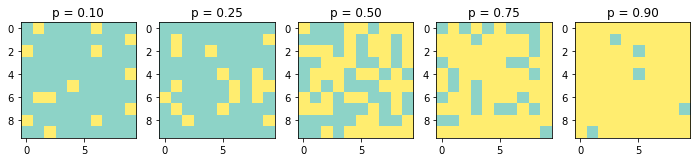

In [3]:
N = 10
p_valores = [0.1,0.25,0.5,0.75,0.9]

fig, axes = plt.subplots(1,len(p_valores),figsize=(12,4))
for i in range(len(p_valores)):
    axes[i].imshow(crear_latice(N,p_valores[i]),cmap='Set3')
    axes[i].set_title('p = %.2f' %(p_valores[i]))
plt.show()

Supongamos que se vierte un material desde el extremo superior de la látice. Si suponemos que el material puede fluir por los sitios ocupados (activos), entonces si este material logra encontrar un camino hasta alcanzar el extremo inferior de la látice, decimos que el material *percola*. Por ejemplo, supongamos cada sitio ocupado representa un árbol en un bosque y también supongamos que un arbol que se quema también quema a sus 4 vecinos. Si se quemaran todos los árboles en el extremo superior de la látice (primera fila) y el fuego lograra llegar al extremo inferior de la látice (última fila), diríamos que el fuego *percoló* a travéz del bosque.

Para explorar si un material podría percolar a través de nuestra látice primero identifiquemos todas las **componentes** que se forman en nuestra látice. Es decir, identifiquemos aquellos grupos de sitios ocupados que sean vecinos entre sí. Para ello construimos un arreglo que registra la componente de cada sitio utilizando dos funciones: 

- `formar_componentes()`: la cual recibe una látice de $N \times N$ y retorna un arreglo de $N \times N$ que indica el número de componente a la que pertence cada sitio ocupado (`0` es el valor que reciben los sitios "vacios"). Para construir este arreglo se recorren los sitios de la látice y se les asigna un número de componente con la función `asignar_componente()`
- `asignar_componente()`: esta función revisa si un sitio está ocupado y en caso de no tener una componente asignada se le asigna una y se le pide a sus cuatro vecinos que hagan lo mismo recursivamente.

**Nota:** Dado que python no es un lenguaje funcional la programación recursiva puede provocar algunos errores. Por ejemplo, para látices grandes con alta ocupación (valores grandes de `N` con valores altos de `p`) el gran número de veces que la función `asignar_componente()` es invocada puede arrojar un error que indica que hemos alcanzado la máxima profundidad de recusión permitida `RecursionError: maximum recursion depth exceeded in comparison`. Existen otros algoritmos más eficientes no recursivos para calcular las componentes conectadas en látices regulares como se describe en los ejercicios finales del notebook. Además, existen paquetes y funciones especializadas para hacer estos cálculos como la función [`measurements.label()`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) de la paquetería `scipy.ndimage`.


In [4]:
def formar_componentes(latice):
    # arreglo donde se registran las componentes a las que 
    # pertenece cada sitio de la látice (se inicializa 
    # con 0, valor que representa sitios no ocupados)
    componentes = np.zeros((N,N)).astype(int) 

    num_componente = 1

    # se recorren los indices de la látice
    for i in range(N):
        for j in range(N):
            # cuando se encuentra un sitio "ocupado" sin 
            # componente se le asigna una
            if latice[i][j] and not componentes[i][j]:
                asignar_componente(latice,componentes,i,j,num_componente)
                num_componente += 1
    return componentes

# esta función recibe una látice, un arreglo de componentes, 
# la posición de la entrada del sitio (i,j) y el numero 
# de componente que se le asignará
def asignar_componente(latice,componentes,i,j,num_componente):
    # si estoy fuera de los índices del arreglo, no hago nada
    if (i<0) or (i>=len(latice)) or (j<0) or (j>=len(latice)):
        return
    # si no soy un sitio "ocupado", no hago nada
    if not latice[i][j]:
        return
    # si ya tengo asignada una componente, no hago nada
    if componentes[i][j]:
        return
    # si estoy ocupado y no se me haya asignado componente
    # se me asigna una y le pido a mis cuatro vecinos que 
    # hagan lo mismo recursivamente
    componentes[i][j] = num_componente
    asignar_componente(latice,componentes,i-1,j  ,num_componente) # vecino de arriba
    asignar_componente(latice,componentes,i  ,j+1,num_componente) # vecino de la derecha
    asignar_componente(latice,componentes,i+1,j  ,num_componente) # vecino de abajo
    asignar_componente(latice,componentes,i  ,j-1,num_componente) # vecino de la izquierda

Veamos un ejemplo de cómo se obtienen las componentes para una látice:

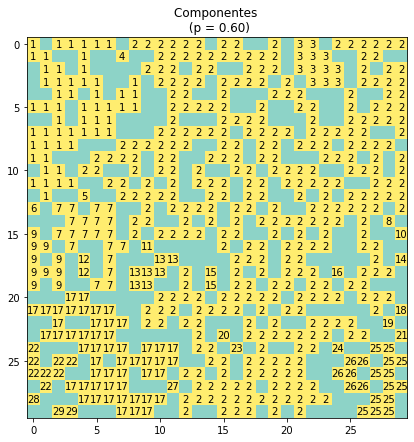

In [5]:
N = 30
p = 0.6

latice = crear_latice(N,p)
componentes = formar_componentes(latice)

plt.figure(figsize=(7,7))
plt.imshow(latice,cmap='Set3')
for (i,j), num_componente in np.ndenumerate(componentes):
    if num_componente != 0:
        plt.text(j,i,num_componente,ha='center',va='center')
plt.title('Componentes \n (p = %.2f)' %(p))
plt.show()

Ahora, para saber si un material podría percolar verticalmente en nuestra látice, se revisa si hay componentes que inicien en el extremo superior y termine en el extremo inferior del arreglo. Para ello definimos una función que retorna las componentes que percolan verticalmente obteniendo los elementos que se compartan entre la primera y la última fila de nuestro arreglo de componentes (se omite el `0`, ya que este representa los sitios vacios). 

In [6]:
def obtener_componentes_que_percolan_verticalmente(componentes):
    primera_fila = componentes[0]
    ultima_fila = componentes[ len(componentes)-1 ]
    componentes_que_percolan_verticalmente = [comp for comp in list(np.intersect1d(primera_fila,ultima_fila)) if comp > 0]
    return componentes_que_percolan_verticalmente

Dibujemos un ejemplo de cómo funciona esta nueva función:

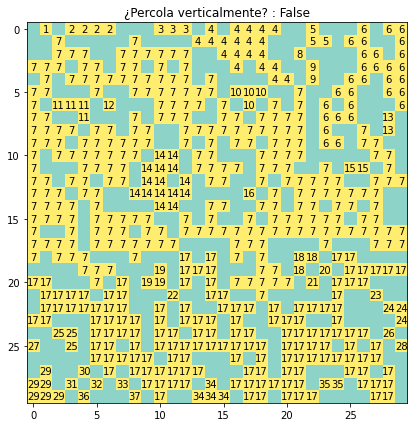

In [7]:
N = 30
p = 0.6

latice = crear_latice(N,p)
componentes = formar_componentes(latice)
componentes_que_percolan_verticalmente = obtener_componentes_que_percolan_verticalmente(componentes)

plt.figure(figsize=(7,7))
plt.imshow(latice,cmap='Set3')
for (i,j), num_componente in np.ndenumerate(componentes):
    if num_componente != 0:
        if num_componente in componentes_que_percolan_verticalmente:
            plt.text(j,i,num_componente,color='#E85160',ha='center',va='center',fontweight='bold')
        else:
            plt.text(j,i,num_componente,ha='center',va='center')
plt.title('¿Percola verticalmente? : %s' %(bool(componentes_que_percolan_verticalmente)))
plt.show()

Otra variable relevante a estudiar en nuestra látice regular (y la variable que monitorearemos cuando estudiemos la percolación en redes) es el **tamaño de nuestra máxima componente**. Para hacer esto, definimos una nueva función `obtener_tamanio_max_comp()` que calcula dicho valor a partir de un diccionario con el tamaño de todas las componentes registradas en nuestro arreglo de componentes.

In [8]:
def obtener_tamanio_max_comp(componentes):
    # se obtiene una lista con los números de las componentes
    # y otra que cuenta cuantas veces aparecen en la látice 
    # (i.e., el tamaño de cada una)
    valores, conteo = np.unique(componentes, return_counts=True)
    cuenta = dict(zip(valores,conteo))
    
    # se quitan los sitios no ocupados del 
    # diccionario
    if 0 in cuenta:
        cuenta.pop(0)

    tamanio_max_componente = max(cuenta.values(),default=0)
    max_comps = [ num_comp for num_comp, tamanio in cuenta.items() if tamanio == tamanio_max_componente ]
    return tamanio_max_componente, max_comps

Veamos un ejemplo:

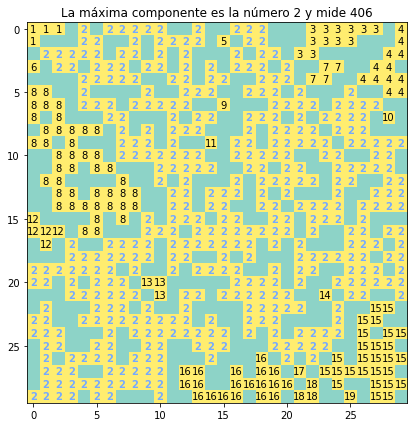

In [9]:
N = 30
p = 0.6

latice = crear_latice(N,p)
componentes = formar_componentes(latice) 
tamanio_max_componente, max_componentes = obtener_tamanio_max_comp(componentes)

plt.figure(figsize=(7,7))
plt.imshow(latice,cmap='Set3')
for (i,j), num_componente in np.ndenumerate(componentes):
    if num_componente != 0:
        if num_componente in max_componentes:
            plt.text(j,i,num_componente,color='#75AAFF',ha='center',va='center',fontweight='bold')
        else:
            plt.text(j,i,num_componente,ha='center',va='center')
plt.title('La máxima componente es la número %i y mide %i' %(max_componentes[0],tamanio_max_componente))
plt.show()

Ahora que ya tenemos todos los elementos necesarios podemos explorar cómo se comportan la **probabilidad de percolación** y el **tamaño de la máxima componente** para múltiples valores de la probabilidad de ocupación, $p$. Para ello vamos a integrar todas las funciones que definimos en las subsecciones anteriores en una sola función llamada `percolacion()` y vamos a realizar un experimento donde exploramos múltiples valores de la probabilidad de ocupación con múltiples repeticiones para cada valor.

In [10]:
def percolacion_latice(N,p):
    latice = crear_latice(N,p)
    componentes = formar_componentes(latice)
    percola = bool(obtener_componentes_que_percolan_verticalmente(componentes))
    tamanio_max_comp,_ = obtener_tamanio_max_comp(componentes)

    return latice, componentes, percola, tamanio_max_comp

Ahora corramos experimentos. Para ello primero definimos una lista con todos los valores de $p$ que vamos a explorar. Luego para cada valor de $p$ creamos `repeticiones` número de látices y para cada una calculamos el tamaño de la máxima componente y si percola y promediamos los resultados de todas las repeticiones. Finalmente graficamos los resultados.

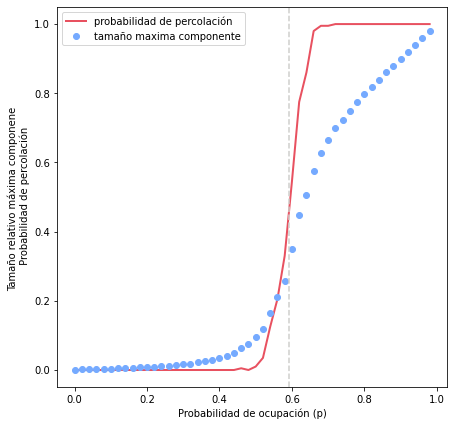

In [11]:
N = 30 # tamaño de la látice

probs_ocupacion = np.arange(0,1,step=0.02) # valores de probabilidad de ocupación a explorar
repeticiones = 200

# listas donde se guardarán los resultados de las simulaciones
promedios_tamanio_max_comp = []
promedios_percola = []

for prob in probs_ocupacion:
    resultados_repeticion_tamanio_max_comp = []
    resultados_repeticion_percola = []
    for repeticion in range(repeticiones):
        _,_, percola, tamanio_comp = percolacion_latice(N,prob)
        resultados_repeticion_tamanio_max_comp.append(tamanio_comp)
        resultados_repeticion_percola.append(percola)

    promedio_tamanio_max_comp = np.mean(resultados_repeticion_tamanio_max_comp)
    promedios_tamanio_max_comp.append(promedio_tamanio_max_comp)
    promedio_percola = np.mean(resultados_repeticion_percola)
    promedios_percola.append(promedio_percola)

# se grafican los resultados
x = probs_ocupacion
y1 = np.array(promedios_percola)
y2 = np.array(promedios_tamanio_max_comp)/(N**2)

plt.figure(figsize=(7,7))
plt.plot(x,y1,label='probabilidad de percolación',color='#E85160',linewidth=2)
plt.plot(x,y2,'o',label='tamaño maxima componente',color="#75AAFF")
plt.axvline(x=0.593,color="#CFCFCC",linestyle='--')
plt.ylabel('Tamaño relativo máxima componene \n Probabilidad de percolación')
plt.xlabel('Probabilidad de ocupación (p)')
plt.legend()
plt.show()

Al ver estos resultados podemos ver claramente que **existe un valor crítico ($p_c$) de la probabilidad de ocupación** que permite identificar dos comportamientos distintos en el sistema:
- Si $p > p_c$ entonces el sistema percola y se forma una componente grande.
- Si $p < p_c$ entonces el sistema no percola y solamente se forman múltiples componentes muy pequeñas.

En el caso de la látice cuadrada tenemos que $p_c \approx 0.593$ (línea punteada en la figura). Sin embargo, este valor depende del tipo de látice (e.g., $p_c = \frac{1}{2}$ para látices triangulares) y de la dimensión del sistema (e.g., $p_c \approx 0.3116$ para una látice cúbica).

Estos resultado se pueden reinterpretar para el caso de la percolación en redes. Consideremos a esta látice como una red regular donde cada "sitio" representa un nodo concectado a sus vecinos ocupados:

![Latice cuadrada como una red](https://i.imgur.com/QVmqf2o.png)

Ahora, si en lugar de considerar a la probabilidad de ocupación ($p$) consideramos la fracción de nodos removidos ($f = 1 - p$), entonces podemos concluir que existe un valor critico $f_c$, tal que (ver siguiente figura):
- Si $f < f_c$ entonces tenemos una componente gigante
- Si $f > f_c$ entonces la componente gigante desaparece y la red se rompe en múltiples componentes pequeñas

Pero... ¿qué pasa cuando las redes no son regulares?

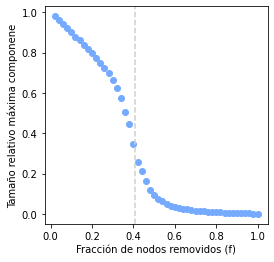

In [12]:
plt.figure(figsize=(4,4))
plt.plot(1-x,y2,'o',label='tamaño maxima componente',color="#75AAFF")
plt.axvline(x=1 - 0.593,color="#CFCFCC",linestyle='--')
plt.ylabel('Tamaño relativo máxima componene')
plt.xlabel('Fracción de nodos removidos (f)')
plt.show()

## Percolación en redes

Hay multiples formas como podríamos ir quitando los nodos de nuestra red. La forma más simple es elegir aleatoriamente dichos nodos, lo cual puede representar **fallas** aleatorias de los elementos de nuestro sistema (e.g., una error en el funcionamiento de un generador eléctrico o de un enrutador). Otra forma es realizando **ataques** a nuestra red con el objetivo de hacerle daño, por lo que en lugar de remover nodos aleatoriamente se quitan con base en su importancia para el sistema (i.e., por su alta centralidad). 

En el caso de las redes como no tenemos "extremos" espacialmente definidos que nos indiquen si un material podría percolar a traves de nuestro sistema, **la variable que exploraremos es el tamaño de la máxima componente** ($S$).

A diferencia de la exploración que hicimos de la percolación de la látice cuadrada (donde implementamos todo manualmente), simular la percolación en redes resulta muy sencillo gracias a todos los métodos que nos ofrece NetworkX. Comencemos importando las librerias necesarias para esta sección.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

Definamos una función que simula la percolación. Esta función recibe una red cualquiera, un valor $f$, la proporción de nodos que se le van a remover y un valor booleano que determina si queremos simular la remoción de nodos por ataques o por fallas (como valor predeterminado le decimos que simule fallas). Primero se calculan la cantidad de nodos a remover, luego, de acuerdo al método de percolación se seleccionan los nodos a remover. En el caso de las *fallas* se seleccionan aleatoriamente los nodos y en caso de los *ataques* se ordenan los nodos por su centralidad de grado y se seleccionan primero aquellos con mayores valores. Finalmente se remueven los nodos y se calcula y retorna el tamaño de la componente más grande.

In [14]:
def percolacion_red(G,f,ataque=False):
    num_nodos_a_remover = int(f * G.number_of_nodes())

    if(ataque):
        nodos = [nodo for nodo,grado in sorted(G.degree(),key=lambda item:item[1],reverse=True)]
        nodos_a_remover = nodos[0:num_nodos_a_remover]
    else:
        nodos = list(G.nodes)
        nodos_a_remover = random.sample(nodos,num_nodos_a_remover)

    G.remove_nodes_from(nodos_a_remover)
    tamanio_max_comp = len(max(nx.connected_components(G),key=len))

    return tamanio_max_comp

Veamos gráficamente como funciona nuestra nueva función:

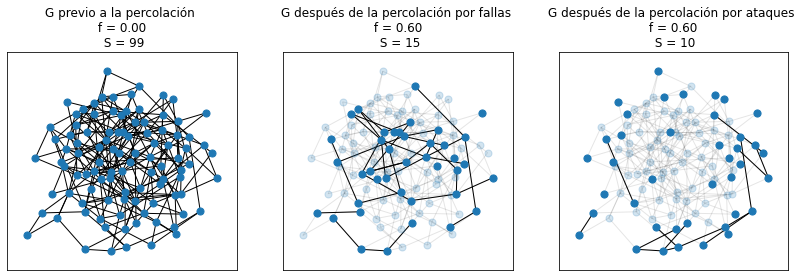

In [15]:
N = 100
p = 0.05

f = 0.6

G = nx.gnp_random_graph(N,p)
G_1 = G.copy()
G_2 = G.copy()
pos = nx.kamada_kawai_layout(G)

fig, axs = plt.subplots(1,3,figsize=(14,4))
# se calcula el tamaño de la máxima componente
# y se grafica previo a la percolación (f=0)
tamanio_max_comp = percolacion_red(G,0)
nx.draw_networkx(G,pos,with_labels=False,ax=axs[0],node_size=50)
axs[0].set_title('G previo a la percolación \n f = %.2f \n S = %i' %(0,tamanio_max_comp))

# se corre la percolación por fallas en esa 
# misma red y se grafica
tamanio_max_comp = percolacion_red(G_1,f)
nx.draw_networkx_edges(G,pos,alpha=0.1,ax=axs[1]) # se grafican enlaces originales como referencia
nx.draw_networkx_nodes(G,pos,node_size=50,ax=axs[1],alpha=0.2) # se grafican nodos originales como referencia
nx.draw_networkx(G_1,pos,with_labels=False,ax=axs[1],node_size=50)
axs[1].set_title('G después de la percolación por fallas \n f = %.2f \n S = %i' %(f,tamanio_max_comp))

# se corre la percolación por ataques en una
# copia de la red original
tamanio_max_comp = percolacion_red(G_2,f,ataque=True)
nx.draw_networkx_edges(G,pos,alpha=0.1,ax=axs[2]) # se grafican enlaces originales como referencia
nx.draw_networkx_nodes(G,pos,node_size=50,ax=axs[2],alpha=0.2) # se grafican nodos originales como referencia
nx.draw_networkx(G_2,pos,with_labels=False,ax=axs[2],node_size=50)
axs[2].set_title('G después de la percolación por ataques \n f = %.2f \n S = %i' %(f,tamanio_max_comp))

plt.show()

Ahora experimentemos para ver cómo cambia el tamaño de la máxima componente con distintos valores de $f$ y en distintos tipos de redes: en redes aleatorias con distribución de poisson (Erdös-Rényi) y en redes libres de escala (Barabási-Albert). Para crear nuestras redes utilizaremos las funciones de NetworkX `gnm_random_graph(N,L)`, que crea una red aleatoria Erdös-Rényi con $N$ nodos y $L$ enlaces, y `barabasi_albert_graph(N,m)`, que crea una red libre de escala con $N$ nodos a partir de ir creciendo una red tipo estrella (con $m+1$ nodos y $m$ enlaces) agregando $m$ enlaces con cada nuevo nodo que se introduce. Para que esta comparación sea apropiada debemos correr los experimentos con redes con el mismo número de nodos y enlaces, por lo que a partir de $N$ y $m$ calculamos el valor de $L$ (una red de Barabási-Albert tiene $L=m(N-m)$ enlaces). 



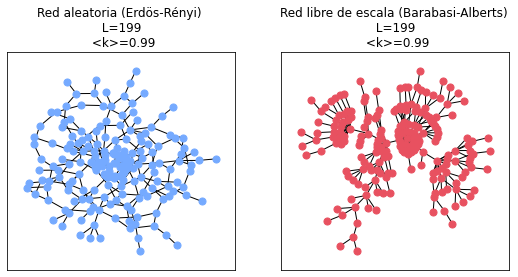

In [16]:
N = 200
m = 1
L = m*(N-m)

# se grafican ejemplos
G = nx.gnm_random_graph(N,L)
H = nx.barabasi_albert_graph(N,m)
posG = nx.kamada_kawai_layout(G)
posH = nx.kamada_kawai_layout(H)

fig, axs = plt.subplots(1,2,figsize=(9,4))
nx.draw_networkx(G,posG,with_labels=False,ax=axs[0],node_size=50,node_color="#75AAFF")
axs[0].set_title('Red aleatoria (Erdös-Rényi) \n L=%i \n <k>=%.2f' %(G.number_of_edges(),G.number_of_edges()/N))
nx.draw_networkx(H,posH,with_labels=False,ax=axs[1],node_size=50,node_color="#E85160")
axs[1].set_title('Red libre de escala (Barabasi-Alberts) \n L=%i \n <k>=%.2f' %(H.number_of_edges(),H.number_of_edges()/N))
plt.show()

Ahora definamos una función para experimentar que corra nuestros experimentos. Esta función nos retornará un DataFrame de pandas y recibirá los siguientes argumentos:

- `f_valores`: los valores de $f$ que vamos a explorar
- `repeticiones`: el número de repreticiones que vamos a realizar para cada valor de $f$ a explorar
- `ataque`: una cadena texto indique si queremos que la percolación se corra por "ataque" o "falla"
- `generar_red_callback`: una función que genera las redes que queremos percolar. Un callback es una función que es pasada a otra función para que esta última la ejecute cuando la necesite, es un concepto muy útil en progamacion. En este paso nuestro callback serán las funciones de NetworkX `gnm_random_graph` y `barabasi_albert_graph`.
- `*args`: los argumentos que utiliza la función `generar_red_callback` cuando es ejecutada (e.g., `N`,`L`,`m` dependiendo de nuestro callback)

In [17]:
def experimento_percolacion_redes(f_valores,repeticiones,ataque,generar_red_callback,*args):
    # listas donde se guardaran los resultados 
    # de las simulaciones
    promedios_tamanio_max_comp = []

    for f in f_valores:
        resultados_repeticiones_tamanio_max_comp = []
        for repeticion in range(repeticiones):
            # se crea una red ejecutando el callback
            # y pasándole los argumentos que necesita
            G = generar_red_callback(*args) 
            tamanio_comp = percolacion_red(G,f,ataque)
            resultados_repeticiones_tamanio_max_comp.append(tamanio_comp)

        promedio_tamanio_max_comp = np.mean(resultados_repeticiones_tamanio_max_comp)
        promedios_tamanio_max_comp.append(promedio_tamanio_max_comp)

    return promedios_tamanio_max_comp

Finalmente, definamos nuestros parámetros de la red y de los experimentos, corrámosolo y grafiquemos nuestros resultados:

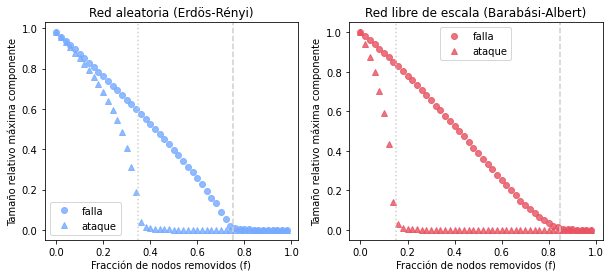

In [18]:
# parámetros de las redes
N = 10000 # nodos
m = 2
L = m*(N-m) 

# parámetros experimentos
f_valores = np.arange(0,1,step=0.02)
repeticiones = 30

# corremos los experimentos y los guardamos
resultado_ER_falla = experimento_percolacion_redes(f_valores,repeticiones,False,nx.gnm_random_graph,N,L)
resultado_SF_falla = experimento_percolacion_redes(f_valores,repeticiones,False,nx.barabasi_albert_graph,N,m)
resultado_ER_ataque = experimento_percolacion_redes(f_valores,repeticiones,True,nx.gnm_random_graph,N,L)
resultado_SF_ataque = experimento_percolacion_redes(f_valores,repeticiones,True,nx.barabasi_albert_graph,N,m)

# graficamos los resultados
x = f_valores
y1 = np.array(resultado_ER_falla)/N
y2 = np.array(resultado_SF_falla)/N
y3 = np.array(resultado_ER_ataque)/N
y4 = np.array(resultado_SF_ataque)/N

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x,y1,'o',alpha=0.8,label='falla',color='#75AAFF')
axs[0].plot(x,y3,'^',alpha=0.8,label='ataque',color='#75AAFF')
axs[0].set_title('Red aleatoria (Erdös-Rényi)')
axs[0].set_ylabel('Tamaño relativo máxima componente')
axs[0].set_xlabel('Fracción de nodos removidos (f)')
axs[0].legend()
axs[0].axvline(x=0.75,color="#CFCFCC",linestyle='--')
axs[0].axvline(x=0.35,color="#CFCFCC",linestyle=':')

axs[1].plot(x,y2,'o',alpha=0.8,label='falla',color='#E85160')
axs[1].plot(x,y4,'^',alpha=0.8,label='ataque',color='#E85160')
axs[1].set_title('Red libre de escala (Barabási-Albert)')
axs[1].set_ylabel('Tamaño relativo máxima componente')
axs[1].set_xlabel('Fracción de nodos removidos (f)')
axs[1].legend()
axs[1].axvline(x=0.85,color="#CFCFCC",linestyle='--')
axs[1].axvline(x=0.15,color="#CFCFCC",linestyle=':')

plt.show()

Estos resultados muestran varias cosas interesantes. 


Si primero nos fijamos en la percolacion por fallas vemos que la red aleatora Erdös-Rényi presenta un comportamiento similar al de la látice, ya que presenta un valor crítico $f_c$ (para este ejemplo $f_c \approx 0.75$; ver [seccion 8.C](http://networksciencebook.com/chapter/8#advanced-8c) y [seccion 8.F](http://networksciencebook.com/chapter/8#advanced-8f) del libro de Barrabási para ver cómo se pueden calcular estos valores críticos) que define dos comportamientos: 

- si $f>f_c$ entonces solamente hay pequeños clusters y no existe una componente gigante
- si $f<f_c$ entonces aparece una componente gigante que crece de acuerdo a la candidad de nodos presentes

En contraste, en el caso de la red libre de escala la componente gigante solo desaparece cuando $f$ está muy cerca de 1, es decir, cuando se remueve casi la totalidad de los nodos (en el caso de redes libre de escala *infinitas* no existe un valor crítico; todo esto lo discute analíticamente Newman en el capítulo 16 de su libro). Así pues, **ante las fallas las redes libres de escala son más robustas que las redes aleatorias**. Esta propiedad de las redes libre de escala permite explicar la alta tolerancia a errores que caracteriza a varios sistemas reales. Por ejemplo, el mantenimiento de las funciones de los organismos a pesar de errores en su metabolismo, o la robustes de la Internet a pesar del recurrente fallo en el funcionamiento de enrutadores. Estas ideas fueron exploradas por primera vez por [Albert, Jeong y Barabási (2000)](https://www.nature.com/articles/35019019) (la figura 3 de este articulo es similar a la que construimos, sin embargo, nota que dicha figura tiene [un error que posteriormente corrigieron los autores](https://www.nature.com/articles/35054111) en la red aleatoria ante fallas).

Pero... ¿qué pasa si en lugar de remover los nodos aleatoriamente atacamos primero a los *hubs*? En el caso de la percolación por ataques vemos el comportamiento contrario, es decir, **ante los ataques las redes aleatorias son más robustas que las libres de escala**. Esto se debe a que en este último tipo de redes la conectividad está mantenida por unos cuantos nodos que al ser removidos rompen rápidamente la red en pequeños clusters. En contraste, la red aleatoria muestra una mayor tolerancia ya que todos sus nodos aportan de forma similar a la conectividad de la red. Este resultado puede tener interesantes implicaciones en sistemas reales, por ejemplo, si queremos evitar que se propague una enfermedad una estrategia más eficiente que vacunar de forma aleatoria a la población sería primero vacunar a los *hubs* o superpropagadores.

Por lo tanto aquí tenemos una disyuntiva entre robustes ante ataques o a fallas. Si quisiéramos diseñar una red robusta ante ambos eventos ¿cómo debería ser su estructura? Esto se discute en la [sección 8.7](http://networksciencebook.com/chapter/8#buildin-robustness) del libro de Barabasi. Evidentemente la red más robusta sería aquella donde todos los nodos esten conectados con todos, sin embargo, mantener una red así sería muy costoso y poco realista. A grandes rasgos una solución más óptima a este problema sería a través de una red con una distribución bimodal, donde se tuviera un nodo con grado $k_{max}$ altamente conectado y el resto de los nodos tuvieran grado $k_{min}$.

## Ejercicios

### Ejercicio 1: Percolación en redes reales

**Dificultad: Baja**

**Carga los datos de una red real y utilizando las funciones definidas en la sección anterior explora como se comporta ante fallas y ataques y grafica tus resultados.** 

¿La red es robusta ante fallas aleatorias? ¿Qué tan sensible es a los ataques? ¿Qué implicaciones podría tener este comportamiento para el sistema real que representa la red?

**Tip**: para usar la función `experimento_percolacion_redes` definida anteriormente se requiere una función "callback" para crear la red. Para pasarle la red real puedes definir una [función anónima o lambda](https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/) que reciba como único parámetro una red y retorne la red y a ésta pasarle una copia de la red real.

In [19]:
# cargar datos...


# crear red...


# correr experimento de percolación


# graficar resultados


### Ejercicio 2: Percolación por enlaces

**Dificultad: Media**

En este notebook solamente se discutió la percolación por nodos o sitios, es decir, el proceso donde se quitan una fracción de nodos junto con sus enlaces. Pero... ¿qué pasa si en lugar de quitar nodos quitamos enlaces? Para investigarlo define una función llamada `percolacion_red_enclaces()` análoga a la función `percolacion_red()` definida anteriormente, pero que en lugar de quitar una fracción $f$ de nodos, quite una fracción $f$ de enlaces.

**Obtener una gráfica donde se compare la percolación por nodos y por enlaces para una red aleatoria y una red libre de escala**.

¿Qué comportamiento observas? ¿A través de cuál de los dos tipos de percolación se rompe más rápido la red? ¿Obtienes valores críticos diferentes de $f$ para cada tipo de percolación? ¿Cómo se comporta la red real que exploraste en el ejercicio anterior a la percolación por enlaces?

**Tip**: Para simular ataques en este caso podemos utilizar una medida de _centralidad de enlaces_, por ejemplo, la centralidad de intermediación de enlace implementada en NetworkX a través de la función: `edge_betweenness_centrality`. Sin embargo, este es un cálculo muy demandande computacionalmente (sobre todo en redes muy grandes), por lo que sugerimos solamente explorar el caso donde se quitan enlaces de forma aleatoria y compararlo con el caso donde se quitan nodos de forma aleatoria.

In [21]:
# define la función para percolar por enlaces


# realiza experimentos


# grafica los resultados comparando con la percolación por nodos



### Ejercicio 3: Algoritmo de Hoshen-Kopelman

**Dificultad: Alta**

Cuando exploramos la percolación en la látice cuadrada de una dimensión al comienzo de este notebook construimos las funciones `formar_componentes()` y `asignar_componente()` para identificar las componentes conectadas en nuestra látice. Lo que hacen estas dos funciones es recorrer celda por celda y cuando encuentran una celda ocupada se le asigna una componente y ésta celda le pide a sus cuatro celadas vecinas que si están ocupadas también se les asigne una componente y que repita el procedimiento con sus vecinas y así sucesivamente. Esta implementación sigue la lógica de los algoritmos de [**búsqueda en profundiad o _Depth First Search (DFS)_**](https://www.youtube.com/watch?v=7fujbpJ0LB4). Sin embargo, este algoritmo es muy poco eficiente y con látices grandes nos puede generar un error: `RecursionError: maximum recursion depth exceeded in comparison`.


Otra forma de encontrar las componentes ocupadas es a través del [**algoritmo de Hoshen-Kopelman**](https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm) que es una aplicación especial del [algoritmo de _union-find_](https://www.youtube.com/watch?v=ayW5B2W9hfo). A grandes rasgos este algoritmo recorre cada una de las celadas de la látice y para las celdas ocupadas verifica si al vecino de arriba y al de la izquierda ya se les asignó una componente. Aquí pueden pasar varias cosas: 
1. si no se les ha asignado se le asigna una nueva; 
2. si la de arriba ya tiene componente asignada entonces le asigna esa (a través de la función `find()`);
3. si la de la izquierda ya tiene componente asignada se le asigna esa (a través de la función `find()`); y
4. si la de arriba y la de la izquierda ya tienen entonces se registra que deben ser componentes iguales (se unen las componentes; a través de la función `union()`) y se le asigna la componente de alguna de ellas (con `find()`). 

Así de este algoritmo obtenemos una látice con algunas vecindades/componentes.

**Implementa el algrotimo de Hoshen-Kopelman para buscar las componentes conectadas en una látice regular de una dimensión**.

**Tip**: Puedes basarte en el [pseudocódigo descrito en Wikipedia](https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm#Pseudocode). Como se describe en esta [explicación más detallada del algoritmo](https://www.ocf.berkeley.edu/~fricke/projects/hoshenkopelman/hoshenkopelman.html) para obtener la matriz con las componentes finales asignadas a cada celda se pueden recorrer una segunda vez todas las celdas con la función `find()`.



In [23]:
# definir funciones union y find


# implementa algoritmo de Hoshen-Kopelman...


# junta las componentes que son la misma


# grafica un ejemplo de látice junto con sus etiquetas de componentes
